In [46]:
from __future__ import annotations

import argparse
import csv
import time
from pathlib import Path
from statistics import mean
from typing import Generator, Tuple

import clingo
import matplotlib.pyplot as plt
import pandas as pd
import secrets
import generator

def run_clingo(h: int, w: int, d: int, program: Path) -> float:
    seed = secrets.randbelow(2**31)
    start = time.perf_counter()
    ctl = clingo.Control(["-c", f"height={h}", "-c", f"width={w}", "-c", f"depth={d}", "--rand-freq=1", "-t 11", f"--seed={str(seed)}"])
    ctl.load(str(program))
    ctl.ground([("base", [])])
    ctl.solve()
    return time.perf_counter() - start

def run_gen1(height, width, depth):
    return run_clingo(height, width, depth, Path("generator.lp"))

def run_gen2(h: int, w: int, d: int) -> float:
    start = time.perf_counter()
    generator.run_generator(h, w, d)
    return time.perf_counter() - start

def run_solver() -> float:
    start = time.perf_counter()
    generator.run_solver()
    return time.perf_counter() - start

def init_csv(path: Path):
    with path.open("w", newline="") as fh:
        csv.writer(fh).writerow(["height", "width", "depth", "run", "seconds", "size"])

def append_csv(path: Path, h: int, w: int, d: int, run_idx: int, seconds: float):
    with path.open("a", newline="") as fh:
        csv.writer(fh).writerow([h, w, d, run_idx, f"{seconds:.6f}", h * w * d])

def aggregate(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    grp = df.groupby(["size"]).agg(mean_seconds=("seconds", mean)).reset_index()
    grp.sort_values("size", inplace=True)
    return grp

def plot_size_vs_time(df: pd.DataFrame, out_svg: Path | None, logscale=True):
    fig, ax = plt.subplots()
    ax.scatter(df["size"], df["mean_seconds"])

    for _, row in df.iterrows():
        x = float(row["size"])
        y = float(row["mean_seconds"])
        ax.annotate(
            f"{int(row['size'])}",
            xy=(x, y),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

    ax.set_xlabel("Problem size (H × W × D)")
    if logscale:
        ax.set_ylabel("Mean runtime (s, log‑scale)")
        ax.set_yscale("log")
    else:
        ax.set_ylabel("Mean runtime (s)")
    ax.set_title("Clingo runtime vs. problem size")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)
    fig.tight_layout()
    if out_svg:
        fig.savefig(out_svg, format="svg")
        print(f"Saved plot to {out_svg}")

    plt.show()

def run(sizes, csv, gen, solver=None, solver_csv=None, n=10):
    total_runs = len(sizes) * n

    current = 0
    for h, w, d, _ in sizes:
        for run_idx in range(1, n + 1):
            current += 1

            print("\r", end="", flush=True)

            print(f"[{current}/{total_runs}] h={h} w={w} d={d} run={run_idx} …", end="", flush=True)

            secs = gen(h, w, d)

            append_csv(csv, h, w, d, run_idx, secs)
            print(f" {secs:.3f}s", end="")

            if solver is not None:
                secs = solver()
                append_csv(solver_csv, h, w, d, run_idx, secs)
                print(f"solve={secs:.3f}s", end=" ")

            print()
    

In [47]:
CSV_GEN1 = Path("results/gen1.csv") # Gen1 = without #programs
CSV_GEN2 = Path("results/gen2.csv") # Gen2 = with #programs
CSV_SOLVER = Path("results/solver.csv")

SVG_GEN1 = Path("results/gen1.svg")
SVG_GEN2 = Path("results/gen2.svg")
SVG_SOLVER = Path("results/solver.svg")

init_csv(CSV_GEN1)
init_csv(CSV_GEN2)
init_csv(CSV_SOLVER)

In [48]:
sizes = []

for i in range(2, 7):
    for j in range(2, 7):
        for h in range(2, 7):
            if i <= j <= h:
                sizes.append((i, j, h, i*j*h))

sizes.sort(key=lambda x: x[3])
print(sizes)

[(2, 2, 2, 8), (2, 2, 3, 12), (2, 2, 4, 16), (2, 3, 3, 18), (2, 2, 5, 20), (2, 2, 6, 24), (2, 3, 4, 24), (3, 3, 3, 27), (2, 3, 5, 30), (2, 4, 4, 32), (2, 3, 6, 36), (3, 3, 4, 36), (2, 4, 5, 40), (3, 3, 5, 45), (2, 4, 6, 48), (3, 4, 4, 48), (2, 5, 5, 50), (3, 3, 6, 54), (2, 5, 6, 60), (3, 4, 5, 60), (4, 4, 4, 64), (2, 6, 6, 72), (3, 4, 6, 72), (3, 5, 5, 75), (4, 4, 5, 80), (3, 5, 6, 90), (4, 4, 6, 96), (4, 5, 5, 100), (3, 6, 6, 108), (4, 5, 6, 120), (5, 5, 5, 125), (4, 6, 6, 144), (5, 5, 6, 150), (5, 6, 6, 180), (6, 6, 6, 216)]


In [49]:
# Run Gen1
run(sizes[0:1], CSV_GEN1, run_gen1, n=10)

[1/10] h=2 w=2 d=2 run=1 … 0.463s
[2/10] h=2 w=2 d=2 run=2 … 0.160s
[3/10] h=2 w=2 d=2 run=3 … 0.120s
[4/10] h=2 w=2 d=2 run=4 … 0.266s
[5/10] h=2 w=2 d=2 run=5 … 0.361s
[6/10] h=2 w=2 d=2 run=6 … 0.165s
[7/10] h=2 w=2 d=2 run=7 … 0.202s
[8/10] h=2 w=2 d=2 run=8 … 0.170s
[9/10] h=2 w=2 d=2 run=9 … 0.178s
[10/10] h=2 w=2 d=2 run=10 … 0.228s


Saved plot to results/gen1.svg


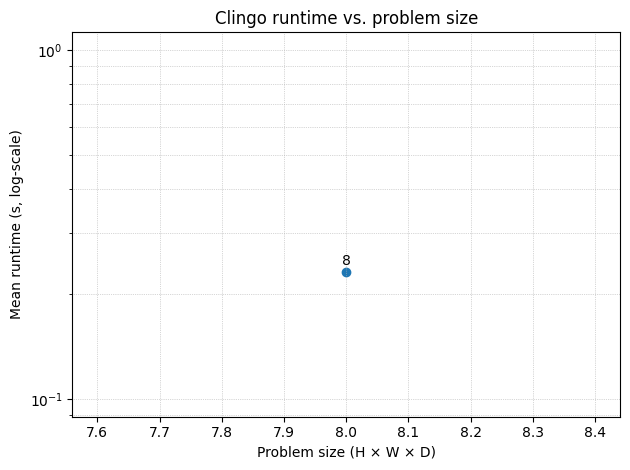

In [50]:
df = aggregate(CSV_GEN1)
plot_size_vs_time(df, SVG_GEN1)